In [1]:
import sys; sys.path.append('/Users/omid/Documents/GitHub/Causality/Quantum_RCC/Scripts')
import numpy as np; np.set_printoptions(precision=4, suppress=True) 
import torch as th; import torch; from torch.utils.data import DataLoader; import torch.nn as nn; import torch.nn.functional as F
import pandas as pd; import networkx as nx
import matplotlib.pyplot as plt; import seaborn as sns; sns.set()
from pathlib import Path; import itertools; import os; import random; import time; import copy
import sklearn; from sklearn.model_selection import train_test_split; from sklearn.ensemble import RandomForestClassifier; from sklearn.neural_network import MLPClassifier
import scipy
import ast
import IPython
from sklearn.metrics import confusion_matrix

import copy
import random

import rcc_functions as rcc
import utilities_functions as uFun
import channel_functions as chFun
import distance_functions as dFun
import simulator_functions as simFun
import pruning_functions as prFun

In [2]:
scenario = 'multi_8node'
n_nodes = 8

simulator_path = f'../../Models/{scenario}/simulator_ijk'
simulator = simFun.nn_simulator(
    n_nodes=n_nodes, batch_size=100, n_epochs=1000, lr=1e-4, patience=100, dim_noise=20,)
simulator.reset_parameters()
simulator.re_load(simulator_path)

kme_container = th.load(f'../../Data/kme_container/{scenario}/org_va.pt')
clf = uFun.object_loader(f'../../Models/{scenario}/causal_classifier')
container_d, container_a = ch_container = th.load(f'../../Data/ch_container/{scenario}/org_va.pt')

# Post-Processing

# Idea 1: 

**Post-process via optimizing the classifier threshold for the edges probabilities**

Average wrong predictions on 135 DAGs => 
Raw (no post-processing): 5.896
Percentile: 3.363


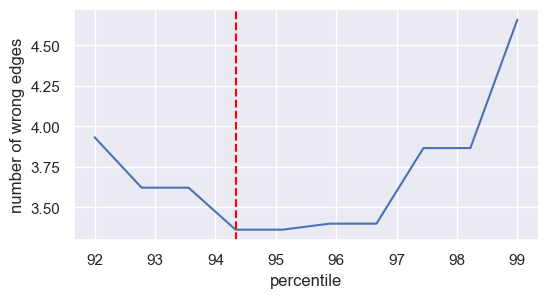

In [3]:
percentile_list = list(np.linspace(92, 99, 10))
nWrongs_list = []
for percentile in percentile_list:
    df_preds = uFun.clf_evaluator_meta(
        kme_container=kme_container,
        clf=clf,
        n_DAGs=-1,
        percentile=percentile,
        predict_both_directions=True,
        saving_path=None,
    )
    nWrongs = df_preds['nWrongs_percentile'].mean()
    nWrongs_list.append(nWrongs)

percentile_opt = percentile_list[np.argmin(nWrongs_list)]
nWrongs_opt = nWrongs_list[np.argmin(nWrongs_list)]
print(f'Optimal percentile: {percentile_opt}\nOptimal n_wrongs:   {nWrongs_opt}')


df_preds = uFun.clf_evaluator_meta(
    kme_container=kme_container,
    clf=clf,
    n_DAGs=-1,
    percentile=percentile_opt,
    predict_both_directions=True,
    saving_path=None,
)

fig, ax = plt.subplots(1, 1, figsize=(6,3))
ax.plot(percentile_list, nWrongs_list)
ax.axvline(x=percentile_opt, color='red', linestyle='--')
ax.set_xlabel('percentile')
ax.set_ylabel('number of wrong edges')
plt.show()
plt.close()

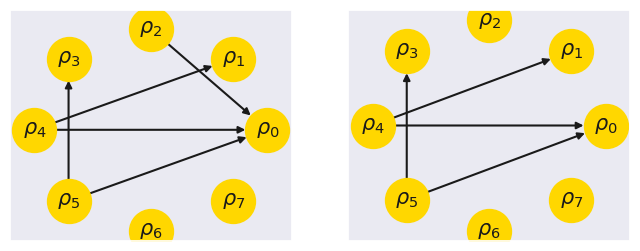

In [4]:
### Example

i=70
A_true = df_preds['A_true'].tolist()[i]
A_pred = df_preds['A_percentile'].tolist()[i]
A_raw = np.where(A_pred>0, 1, 0)
uFun.graph_plotter(A_true, A_raw)

n_samples = len(df_preds)
As_true = df_preds['A_true'].tolist()
As_raw = df_preds['A_binarized'].tolist()
As_opt = df_preds['A_percentile'].tolist()

local_true, local_raw, local_opt = [], [], []

for i in range(n_samples):
    local_true.append(prFun.glb_to_loc(As_true[i]))
    local_raw.append(prFun.glb_to_loc(As_raw[i]))
    local_opt.append(prFun.glb_to_loc(As_opt[i]))

local_true = [x for l in local_true for x in l]
local_raw = [x for l in local_raw for x in l]
local_opt = [x for l in local_opt for x in l]

confusion_raw = confusion_matrix(local_true, local_raw, labels=[1,2,0], normalize='true')#'true'
confusion_opt = confusion_matrix(local_true, local_opt, labels=[1,2,0], normalize='true')


# Idea 2: 

**Hill-climb algorithm using the generative model and the penalty term to prune the edges**

- First, generate a number of fake DAGs each corresponding to one of the valid DAGs => save on disk
- Second, define a set of values for lambda (penalty term) => find the one for which the deviation between the two criteria is minimal 

$$\mathscr{L} = \operatorname{MMD}(\hat{\mathscr{D}}, \mathscr{D}) + \lambda |\mathcal{G}|$$

In [ ]:
# First, generate a number of fake DAGs each corresponding to one of the valid DAGs => save on disk
container_fake = prFun.generate_fakeContainer(
    ch_container_org=ch_container, 
    n_fakesPerDAG=100,
    n_lossRuns=5,
    simulator=simulator,
    saving_path='../../Data/fake_container',
)

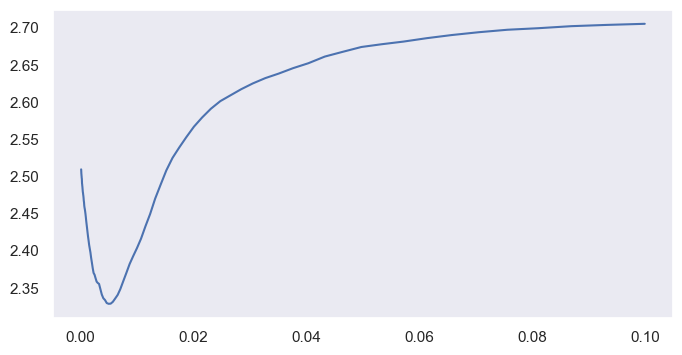

Optimal Lambda    => 0.004977023564332114
Optimal Deviation => 2.3285925925925923
Raw Deviation     => 2.5202222222222224


In [8]:
penalty_weights = np.logspace(-4, -1, 100) #np.logspace(-3, -2, 10)
container_fake = th.load('../../Data/fake_container')

deviations = []
for penalty_weight in penalty_weights:
    df, deviation = prFun.penaltyWg_evaluator(penalty_weight, container_fake)
    deviations.append(deviation)

fig, ax = plt.subplots(figsize = (8,4)) 
ax.plot(penalty_weights, deviations)
#ax.set_xscale('log')#log, linear
plt.show()


lambda_opt = penalty_weights[np.argmin(deviations)]
lambda_raw = 0
df_opt, deviation_opt = prFun.penaltyWg_evaluator(penalty_weight=lambda_opt, container_fake=container_fake)
df_raw, deviation_raw = prFun.penaltyWg_evaluator(penalty_weight=lambda_raw, container_fake=container_fake)
print(f'Optimal Lambda    => {lambda_opt}\nOptimal Deviation => {deviation_opt}\nRaw Deviation     => {deviation_raw}')


In [ ]:
percentile_opt = 0
lambda_opt = 0.0007208715033782136
n_runs = 10
max_iterations = 10

df_preds = uFun.clf_evaluator_meta(
    kme_container = kme_container, 
    clf           = clf, 
    n_DAGs        = -1,
    percentile    = percentile_opt,
    saving_path   = None,
)

df_preds['A_hill'] = None
for index, row in df_preds.iterrows():
    data_true = ch_container[index]
    A_hill = prFun.hill_climbing(
        graph_evaluation,
        A_pred=row['A_percentile'],
        data_true=data_true,
        simulator=simulator,
        penalty_weight,
        n_runs=n_runs,
        max_iterations=max_iterations,
        data_true=data_true,
    )
    df_preds.at[index, 'A_hill'] = A_hill
    df_preds.loc[index, 'nWrongs_hill'] = int(np.abs(row['A_true'] - A_hill).sum())
    
IPython.display.clear_output(wait=True)
nWrongs_raw = df_preds['nWrongs_raw'].mean()
nWrongs_percentile = df_preds['nWrongs_percentile'].mean()
nWrongs_hill = df_preds['nWrongs_hill'].mean()

print('Average Wrong Perdictions:\nRaw        => {}\nPercentile => {}\nHill-Climb => {}'.format(nWrongs_raw, nWrongs_percentile, nWrongs_hill))

# Idea 3 :

- Hill-climb algorithm via combining the edge importances of both generative and discriminative models

In [ ]:
df_preds = uFun.clf_evaluator_meta(
    kme_container=kme_container,
    clf=clf,
    n_DAGs=-1,
    percentile=0,
    predict_both_directions=True,
    saving_path=None,
)

n_runs = 10
penalty_weight = 0

n_samples = len(container_d)

importance_cgnn_list = []
importance_rcc_list = []

for index_sample in range(n_samples):
    data_true = container_d[index_sample]
    A_true = df_preds['A_true'][index_sample].astype(int)
    A_pred = df_preds['A_binarized'][index_sample].astype(int)
    importance_rcc = df_preds['A_pred'][index_sample]
    importance_rcc = importance_rcc/importance_rcc.sum()
    importance_rcc_list.append(importance_rcc)
    importance_cgnn = prFun.get_edges_importance(A=A_pred, data_true=data_true, simulator=simulator, penalty_weight=penalty_weight, n_runs=n_runs,)
    importance_cgnn = importance_cgnn/importance_cgnn.sum()
    importance_cgnn_list.append(importance_cgnn)
    print(index_sample)
    

#df_preds['importance_rcc'] = importance_rcc_list
df_preds['importance_rcc'] = list(len(df_preds)*np.array(df_preds['A_pred'].tolist())/np.array(df_preds['A_pred'].tolist()).sum())
df_preds['importance_cgnn'] = importance_cgnn_list
    
    
importance_rcc = np.array([df_preds['importance_rcc'][index_sample] for index_sample in range(n_samples)])
importance_cgnn = np.array([df_preds['importance_cgnn'][index_sample] for index_sample in range(n_samples)])

As_true = df_preds['A_true'].tolist()
As_pred = df_preds['A_binarized'].tolist()


percentile_list = list(np.linspace(80, 99, 100))
coeff_list = [0]#list(np.linspace(0, 1, 100))

df_comb = pd.DataFrame()
nWrongs_list, percentiles, coeffs = [], [], []

for percentile in percentile_list:
    for coeff in coeff_list:
        importance = importance_rcc + coeff * importance_cgnn
        As_post = np.where((importance>np.percentile(importance, percentile))*importance>0, 1, 0)
        nWrongs = np.mean(
            [np.abs(As_true[i]-As_post[i]).sum() for i in range(n_samples)]
        )
        nWrongs_list.append(nWrongs)
        percentiles.append(percentile)
        coeffs.append(coeff)

df_comb['percentile'] = percentiles
df_comb['coeff'] = coeffs        
df_comb['nWrongs'] = nWrongs_list



optimal_comb = df_comb.iloc[df_comb['nWrongs'].argmin()]
percentile_opt = optimal_comb['percentile']
coeff_opt = optimal_comb['coeff']
nWrongs_opt = optimal_comb['nWrongs']
print(f'Optimal percentile: {percentile_opt}\nOptimal n_wrongs:   {nWrongs_opt}')

fig, ax = plt.subplots(1, 1, figsize=(6,3))
ax.plot(percentile_list, nWrongs_list)
ax.axvline(x=percentile_opt, color='red', linestyle='--')
ax.set_xlabel('percentile')
ax.set_ylabel('number of wrong edges')
plt.show()
plt.close()

#####

importance = importance_rcc + coeff_opt * importance_cgnn

As_post = np.where((importance>np.percentile(importance, percentile_opt))*importance>0, 1, 0)


i=4
A_true = As_true[i]
A_pred = As_pred[i]
A_post = As_post[i]
uFun.graph_plotter(A_true, A_pred, A_post)

print(f'Raw  Wrong: {int(np.abs(A_true-A_pred).sum())}\nHill Wrong: {int(np.abs(A_true-A_post).sum())}')


